#Setup

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

%cd /content/gdrive/My\ Drive/TESIS/autism-master/

Mounted at /content/gdrive/
/content/gdrive/My Drive/TESIS/autism-master


In [ ]:
%%capture
import os
import pandas as pd 
import numpy as np
from scipy import sparse
!pip install pingouin
import pingouin as pg
!pip install git+https://github.com/paris-saclay-cds/ramp-workflow
from problem import get_train_data
from download_data import fetch_fmri_time_series
!pip install ripser
from ripser import ripser
from persim import plot_diagrams
!pip install tensorflow_addons  
!pip install gudhi
import pickle as pkl
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold, ShuffleSplit
from tensorflow import random_uniform_initializer as rui
import gudhi.representations as tda
import tensorflow as tf
import os.path
import itertools
import h5py
import tensorflow_addons  as tfa
import gudhi              as gd
from scipy.sparse           import csgraph
from scipy.io               import loadmat
from scipy.linalg           import eigh
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
# Reduccion dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
!pip install git+https://github.com/MathieuCarriere/perslay
!pip install git+https://github.com/MathieuCarriere/sklearn-tda
from perslay import PerslayModel
from scipy.stats import beta
!pip install nilearn
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [ ]:
def get_all_patients(ids_list, parcelation):
  pacientes = []
  for ID in ids_list:
    path = data_train_functional.loc[data_train_functional['tmp'] == ID, parcelation].item()
    paciente=pd.read_csv(path)
    paciente = np.asarray(paciente)
    pacientes.append(paciente)
  return pacientes


def gen_matrices(lista_pacientes, tipo_matriz, as_distance, keep_pvalue = 1):
  """ lista_pacientes debe ser una lista de arrays de numpy de (n_obs,n_features) cada una
  Y tipo_matriz puede ser cualquiera de 'correlation', 'partial correlation', 'tangent', y 'precision'
  El parámetro as_distance controla si se transforma la matriz a distancia coseno ('cosine'), distancia dinámica ('dynamic'), o ninguna (False)
  Si as_distance no es Falso y la matriz es tangente, entonces usa el argumento máximo para MinMaxScale
  El parámetro keep_pvalue descarta (solo para la matriz de correlación) aquellas correlaciones con significatividad menor a keep_pvalue
  (ej, keep_pvalue = 0.1 deja solamente las correlaciones con p-valor menor o igual a 0.1)
  TEST: agregar as_distance euclidean y mahalanobis
  """

  if (tipo_matriz == 'euclidean') or (tipo_matriz == 'mahalanobis'):
    matrices = []
    for pac in lista_pacientes:
      matrix = pdist(pac, metric= tipo_matriz)
      matrix = squareform(matrix)
      matrices.append(matrix)
    matrices = np.array(matrices)

  else:
    connect = ConnectivityMeasure(kind = tipo_matriz)
    matrices = connect.fit_transform(lista_pacientes)

    if (keep_pvalue < 1) and (tipo_matriz == 'correlation'):
      for i in range(matrices.shape[0]):
        matrix = non_trivial_correlation(lista_pacientes[i], matrices[i], threshold = keep_pvalue)
        matrices[i] = matrix
    if (as_distance == 'cosine') and (tipo_matriz != 'tangent'):
      for i in range(matrices.shape[0]):
        matrices[i] = np.sqrt(2*(1-matrices[i]))
    if (as_distance == 'dynamic') and (tipo_matriz != 'tangent'):
      for i in range(matrices.shape[0]):
        matrices[i] = 1-np.abs(matrices[i])

    if (as_distance == 'cosine') and (tipo_matriz == 'tangent'):
      max_value = np.amax(np.abs(matrices)) + 0.1
      for i in range(matrices.shape[0]):
        matrices[i] = np.sqrt(2*(1-matrices[i]/max_value))
    if (as_distance == 'dynamic') and (tipo_matriz == 'tangent'):
      max_value = np.amax(np.abs(matrices)) + 0.1
      for i in range(matrices.shape[0]):
        matrices[i] = 1-np.abs(matrices[i]/max_value)

  return matrices

def non_trivial_correlation(X, corrmat, threshold=0.1): # Ver https://stackoverflow.com/questions/59416390/how-can-i-compute-the-pearson-correlation-matrix-and-retain-only-significant-val
    n = X.shape[0] # Es para hacer el threshold del p-valor
    p = 2 * beta(n/2 - 1, n/2 - 1, loc=-1, scale=2).cdf(-abs(corrmat))
    corrmat[p > threshold] = 0
    return corrmat

def triag_array(array):
    return(array[np.triu_indices_from(array)])

def ripser_diagram(paciente, hom_over_p=2, hom_dimension = 1, distm = True):
    diag = ripser(paciente, distance_matrix=distm, coeff = hom_over_p, maxdim=hom_dimension)['dgms']
    return(diag)

def diag_prepro(diags_dict, use_selector = True, use_prominent = True, thresh = 500, use_scaler = True, use_padding = True):
  
  # https://gudhi.inria.fr/python/3.1.0.rc1/representations.html
  # Whole pipeline
  tmp = Pipeline([
          ("Selector",      tda.DiagramSelector(use=True, point_type="finite")),
          ("ProminentPts",  tda.ProminentPoints(use=True, num_pts=thresh)),
          ("Scaler",        tda.DiagramScaler(use=True, scalers=[([0,1], MinMaxScaler())])),
          ("Padding",       tda.Padding(use=True)),
                  ])

  prm = {filt: {"ProminentPts__num_pts": min(thresh, max([len(dgm) for dgm in diags_dict[filt]]))} 
        for filt in diags_dict.keys() if max([len(dgm) for dgm in diags_dict[filt]]) > 0}

  # Apply the previous pipeline on the different filtrations.
  diags = []
  for dt in prm.keys():
      param = prm[dt]
      tmp.set_params(**param)
      diags.append(tmp.fit_transform(diags_dict[dt]))

  # For each filtration, concatenate all diagrams in a single array.
  D, npts = [], len(diags[0])
  for dt in range(len(prm.keys())):
      D.append(np.array(np.concatenate([diags[dt][i][np.newaxis,:] for i in range(npts)],axis=0),dtype=np.float32))
  
  return D

def load_architecture_params(weight, len_d, layer = "Image", perm_op = "mean"):
  perslay_parameters = []
  perslay_channel = {}

  perslay_channel["pweight_train"] = True
  perslay_channel["layer_train"]   = True
  perslay_channel["final_model"]   = tf.keras.Sequential([tf.keras.layers.Flatten()])

  if layer == "Landscape":
    perslay_channel["layer"]           = "Landscape"
    perslay_channel["lsample_num"]     = 100
    perslay_channel["lsample_init"]    = rui(0.0, 1.0)

  if layer == "Image":
    perslay_channel["layer"]           = "Image"
    perslay_channel["image_size"]      = (20, 20)
    perslay_channel["image_bnds"]      = ((-.001, 2.001), (-.001, 2.001))
    perslay_channel["lvariance_init"]  = 3.


  if weight == "gmix":
    perslay_channel["pweight"]       = "gmix"
    perslay_channel["pweight_num"]   = 3
    perslay_channel["pweight_init"]  = np.array(np.vstack([np.random.uniform(0.,1.,[2,3]),
                                                           5.*np.ones([2,3])]), dtype=np.float32)
  if weight == "power":
    perslay_channel["pweight"]       = "power"
    perslay_channel["pweight_init"]  = 1.
    perslay_channel["pweight_power"] = 1

  if weight == "grid":
    perslay_channel["pweight"]       = "grid"
    perslay_channel["pweight_size"]  = [20,20]
    perslay_channel["pweight_bnds"]  = ((-.001, 1.001), (-.001, 1.001))
    perslay_channel["pweight_init"]  = rui(1.0, 1.0)
  
  if weight == "None":
    perslay_channel["pweight"]       = None

  perslay_channel["perm_op"] = perm_op
  # mean, max, sum, topk

  if perm_op == "topk":
    perslay_channel["keep"]  = 10

  perslay_parameters = [perslay_channel for _ in range(len_d)]

  return perslay_parameters

def vector_representations(D, perslay_parameters):
  mirrored_strategy = tf.distribute.MirroredStrategy()
  with mirrored_strategy.scope():
      
      # Final rho network is a simple dense layer to the number of labels 
      rho = tf.keras.Sequential([tf.keras.layers.Dense(L.shape[1], activation="sigmoid", input_shape=(800,))])
      model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)

      # Optimizer is Adam with exponential decay of learning rate and moving average of variables
      lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.01, decay_steps=20, decay_rate=0.5)
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
      optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 

      # Loss is cross-entropy
      loss = tf.keras.losses.CategoricalCrossentropy()

      # Metric is accuracy
      metrics = [tf.keras.metrics.CategoricalAccuracy()]

  vectors = model.compute_representations(D).numpy()
  return vectors

random_seed=1003
def reduceDim(df, target, method_class = PCA, df_name='Dataset',  **method_params):
    plt.figure(figsize=(10,10))
    plt.title('Reducción de dimensionalidad con {0} para dataset {1}'.format(method_class.__name__, df_name))
    
    target_df=pd.DataFrame({'ind': target.index, 'className': target.values})
    
    method_instance = method_class(n_components=2, random_state = random_seed)
    method_instance.set_params(**method_params)
    principalComponents = method_instance.fit_transform(df)
    
    if method_class == PCA:
        print('Varianza explicada',method_instance.explained_variance_ratio_)
        print('Varianza explicada total',method_instance.explained_variance_ratio_.sum())
    if method_class == TSNE:
        print(' .. cantidad de iteraciones: ', method_instance.n_iter_)
        
    principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
    principalDf_comp = pd.concat([principalDf.reset_index(drop=True),target_df['className'].reset_index(drop=True)], axis=1)
    sns.scatterplot(data=principalDf_comp, x='PC1', y='PC2',
                    palette=sns.color_palette("hls", 2),
                    hue= "className",
                    s=80)
    plt.show()

# Get subjects

In [ ]:
data_train, labels_train = get_train_data()
data_train_functional = data_train[[col for col in data_train.columns if col.startswith('fmri')]]
data_train_functional['tmp'] = data_train_functional.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
path = 'train/prueba_semana26/train_ids_labs.pkl'
with open(path, 'rb') as handle:
    ids_labs = pkl.load(handle)

In [ ]:
train_ids = ids_labs['id'].values

In [ ]:
data_train_anatomy = data_train[[col for col in data_train.columns if not col.startswith('fmri')]]

In [ ]:
sex_code = [0 if i == "M" else 1 for i in data_train_anatomy['participants_sex']]

In [ ]:
data_train_anatomy['participants_sex'] = sex_code

In [ ]:
data_train_anatomy = data_train_anatomy.drop(columns=['anatomy_select'])

In [ ]:
data_train_anatomy.head()

,participants_site,participants_sex,participants_age,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,anatomy_lh_inferiorparietal_area,anatomy_lh_inferiortemporal_area,anatomy_lh_isthmuscingulate_area,anatomy_lh_lateraloccipital_area,anatomy_lh_lateralorbitofrontal_area,anatomy_lh_lingual_area,anatomy_lh_medialorbitofrontal_area,anatomy_lh_middletemporal_area,anatomy_lh_parahippocampal_area,anatomy_lh_paracentral_area,anatomy_lh_parsopercularis_area,anatomy_lh_parsorbitalis_area,anatomy_lh_parstriangularis_area,anatomy_lh_pericalcarine_area,anatomy_lh_postcentral_area,anatomy_lh_posteriorcingulate_area,anatomy_lh_precentral_area,anatomy_lh_precuneus_area,anatomy_lh_rostralanteriorcingulate_area,anatomy_lh_rostralmiddlefrontal_area,anatomy_lh_superiorfrontal_area,anatomy_lh_superiorparietal_area,anatomy_lh_superiortemporal_area,anatomy_lh_supramarginal_area,anatomy_lh_frontalpole_area,anatomy_lh_temporalpole_area,anatomy_lh_transversetemporal_area,anatomy_lh_insula_area,anatomy_lh_WhiteSurfArea_area,anatomy_rh_bankssts_area,anatomy_rh_caudalanteriorcingulate_area,...,anatomy_Right-Accumbens-area,anatomy_Right-VentralDC,anatomy_Right-vessel,anatomy_Right-choroid-plexus,anatomy_5th-Ventricle,anatomy_WM-hypointensities,anatomy_Left-WM-hypointensities,anatomy_Right-WM-hypointensities,anatomy_non-WM-hypointensities,anatomy_Left-non-WM-hypointensities,anatomy_Right-non-WM-hypointensities,anatomy_Optic-Chiasm,anatomy_CC_Posterior,anatomy_CC_Mid_Posterior,anatomy_CC_Central,anatomy_CC_Mid_Anterior,anatomy_CC_Anterior,anatomy_BrainSegVol,anatomy_BrainSegVolNotVentSurf,anatomy_lhCortexVol,anatomy_rhCortexVol,anatomy_CortexVol,anatomy_lhCerebralWhiteMatterVol,anatomy_rhCerebralWhiteMatterVol,anatomy_CerebralWhiteMatterVol,anatomy_SubCortGrayVol,anatomy_TotalGrayVol,anatomy_SupraTentorialVol,anatomy_SupraTentorialVolNotVent,anatomy_SupraTentorialVolNotVentVox,anatomy_MaskVol,anatomy_BrainSegVol-to-eTIV,anatomy_MaskVol-to-eTIV,anatomy_lhSurfaceHoles,anatomy_rhSurfaceHoles,anatomy_SurfaceHoles,anatomy_EstimatedTotalIntraCranialVol,anatomy_eTIV,anatomy_BrainSegVolNotVent,repetition_time
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,5,1,9.301370,977.0,427.0,1884.0,1449.0,463.0,2790.0,4091.0,3305.0,897.0,4406.0,2840.0,2571.0,1693.0,2953.0,669.0,1251.0,1508.0,615.0,1380.0,1267.0,3956.0,926.0,4490.0,4097.0,685.0,5423.0,7040.0,6391.0,3471.0,4013.0,225.0,478.0,415.0,2020.0,81059.6,850.0,534.0,...,604.7,3540.8,13.5,618.4,0.0,532.4,0.0,0.0,0.0,0.0,0.0,263.7,757.6,462.6,446.1,400.8,819.5,1073332.0,1.059829e+06,262826.404548,261285.128186,524111.532734,183110.242509,181879.257294,364989.499803,53149.0,673569.532734,9.548540e+05,9.433810e+05,941139.0,1375171.0,0.840976,1.077472,30.0,31.0,61.0,1.276294e+06,1.276294e+06,1058903.0,2.5
5174041730092253771,19,0,29.000000,1279.0,730.0,2419.0,1611.0,467.0,3562.0,5380.0,3555.0,1155.0,5611.0,2867.0,3412.0,1963.0,4112.0,670.0,1545.0,2342.0,878.0,1961.0,1587.0,4288.0,1330.0,5073.0,4378.0,999.0,6376.0,7851.0,5794.0,4484.0,4689.0,249.0,490.0,448.0,2708.0,96260.5,925.0,911.0,...,740.5,5045.2,51.9,610.1,0.0,696.8,0.0,0.0,0.0,0.0,0.0,163.0,902.0,603.0,527.4,507.9,1044.4,1349407.0,1.329346e+06,284683.699493,287393.006096,572076.705589,268366.061339,271307.630193,539673.691532,70140.0,759505.705589,1.199671e+06,1.183773e+06,1181796.0,1807924.0,0.771229,1.033285,45.0,54.0,99.0,1.749685e+06,1.749685e+06,1329340.0,3.0
10219322676643534800,19,1,45.000000,926.0,446.0,1897.0,2135.0,570.0,3064.0,4834.0,2602.0,1171.0,6395.0,2699.0,3850.0,2009.0,3239.0,660.0,1382.0,1831.0,859.0,1497.0,1771.0,3976.0,1156.0,4953.0,3667.0,742.0,5529.0,6239.0,5947.0,4134.0,4044.0,289.0,381.0,509.0,2331.0,87729.7,817.0,600.0,...,458.8,4024.4,15.5,437.7,0.0,722.2,0.0,0.0,0.0,0.0,0.0,205.0,885.8,540.0,763.9,808.7,608.7,1088861.0,1.072526e+06,223033.559601,221342.0

In [ ]:
data_train_anatomy.shape

(1127, 211)

In [ ]:
data_train_anatomy = data_train_anatomy.loc[train_ids]

In [ ]:
data_train_anatomy.shape

(788, 211)

# Clustering

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_train_anatomy)

In [ ]:
kmeans_kwargs = {"init": "random",
                 "n_init": 10,
                 "max_iter": 300,
                 "random_state": 42
                 }

In [ ]:
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  score = silhouette_score(scaled_features, kmeans.labels_)
  silhouette_coefficients.append(score)

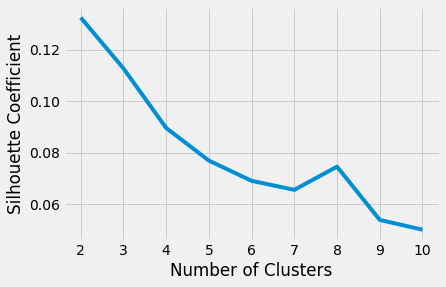

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  sse.append(kmeans.inertia_)

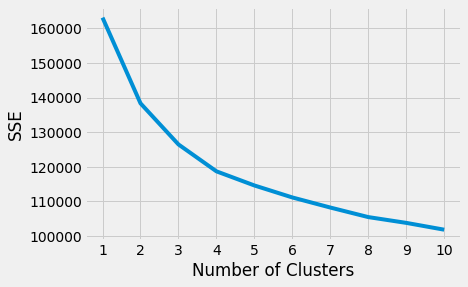

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2, **kmeans_kwargs)
kmeans.fit(scaled_features)
cluster_labels = kmeans.labels_

In [ ]:
ids_labs['cluster_labels'] = cluster_labels

In [ ]:
ids_labs.head()

,id,label,cluster_labels
0,6362958275326218968,0,1
1,7111506141037153650,0,1
2,15632143337475166470,1,1
3,6025747022351864597,1,1
4,16653395447554605567,0,1


In [ ]:
ids_cluster1 = ids_labs[ids_labs['cluster_labels']==0][['id','label']]
ids_cluster2 = ids_labs[ids_labs['cluster_labels']==1][['id','label']]

#Pruebas con clusters KMeans

In [ ]:
pacientes_c1 = get_all_patients(ids_cluster1['id'].values, 'fmri_basc197')

In [ ]:
mats = gen_matrices(pacientes_c1, tipo_matriz = 'correlation', as_distance = 'cosine', keep_pvalue= 0.05)

dgms = []
Len = len(mats)
for i in range(Len):
  dgm = ripser_diagram(mats[i])
  dgms.append(dgm)

Len = len(dgms)
diags_dict = {'Rips_dim_0': [],'Rips_dim_1': []}

for i in range(Len):
  diags_dict['Rips_dim_0'].append(dgms[i][0])
  diags_dict['Rips_dim_1'].append(dgms[i][1])


F = np.array([[]]*Len)

In [ ]:
L = pd.Series(ids_cluster1['label'].values)
L = np.asarray(pd.get_dummies(L))

In [ ]:
labs_df = pd.DataFrame({'label': ids_cluster1['label'].values})

Varianza explicada [0.916281   0.04307289]
Varianza explicada total 0.95935386


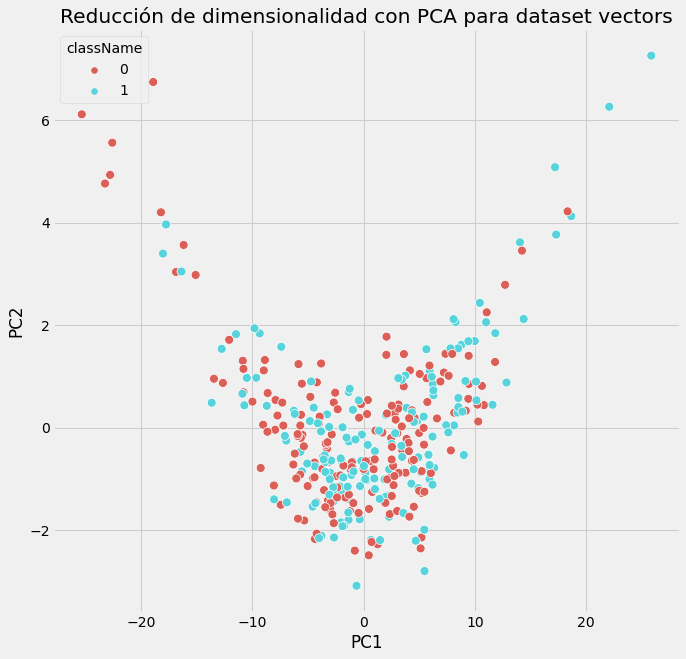

In [ ]:
D = diag_prepro(diags_dict, use_selector = True, use_prominent = False, thresh = 40, use_scaler = True, use_padding = True)

lend = len(D)
perslay_parameters = load_architecture_params(weight="None", len_d = lend, layer= "Landscape", perm_op = "sum")
vectors = vector_representations(D, perslay_parameters)

vec_df = pd.DataFrame(vectors)

reduceDim(df=vec_df,target=labs_df['label'], method_class=PCA, df_name='vectors')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(vec_df, labs_df['label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Actual class predictions
rf_predictions = model.predict(vec_df)
# Probabilities for each class
rf_probs = model.predict_proba(vec_df)[:, 1]

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(labs_df['label'], rf_predictions)

array([[182,   0],
       [  0, 165]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(labs_df['label'], rf_predictions).ravel()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

In [ ]:
X = vec_df
y = labs_df['label']

splits = 10
kf = KFold(n_splits=splits, random_state=1117, shuffle=True)
kf.get_n_splits(X)

accuracy = []

print(kf)

for train_index, test_index in kf.split(X):
  X_train, X_test = X.loc[train_index], X.loc[test_index]
  y_train, y_test = y.loc[train_index], y.loc[test_index]

  # Create the model with 100 trees
  model = RandomForestClassifier(n_estimators=500, 
                                bootstrap = True,
                                max_features = 'sqrt')
  model.fit(X_train, y_train)
  rf_predictions = model.predict(X_test)
  acc = accuracy_score(y_test, rf_predictions)
  accuracy.append(acc)


KFold(n_splits=10, random_state=1117, shuffle=True)


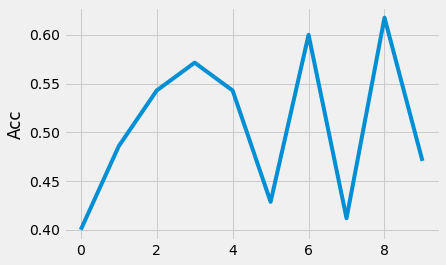

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(splits), accuracy)
plt.ylabel("Acc")
plt.show()

In [ ]:
np.mean(accuracy)

0.5071428571428571

## Cluster 2

Varianza explicada [0.9167851  0.03926015]
Varianza explicada total 0.95604527


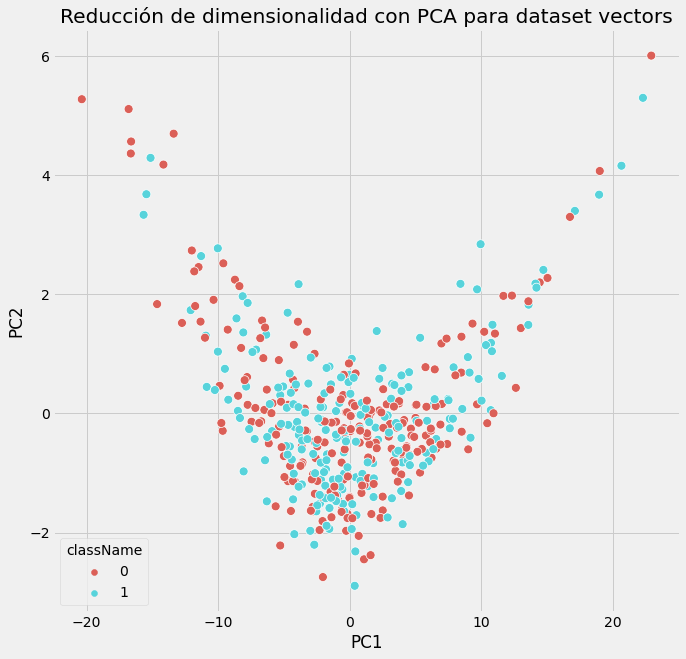

KFold(n_splits=10, random_state=1117, shuffle=True)


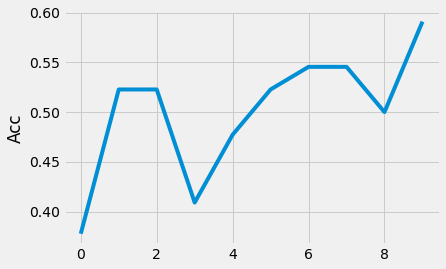

0.5014141414141414

In [ ]:
pacientes_c2 = get_all_patients(ids_cluster2['id'].values, 'fmri_basc197')

mats = gen_matrices(pacientes_c2, tipo_matriz = 'correlation', as_distance = 'cosine', keep_pvalue= 0.05)

dgms = []
Len = len(mats)
for i in range(Len):
  dgm = ripser_diagram(mats[i])
  dgms.append(dgm)

Len = len(dgms)
diags_dict = {'Rips_dim_0': [],'Rips_dim_1': []}

for i in range(Len):
  diags_dict['Rips_dim_0'].append(dgms[i][0])
  diags_dict['Rips_dim_1'].append(dgms[i][1])


F = np.array([[]]*Len)

L = pd.Series(ids_cluster2['label'].values)
L = np.asarray(pd.get_dummies(L))

labs_df = pd.DataFrame({'label': ids_cluster2['label'].values})

D = diag_prepro(diags_dict, use_selector = True, use_prominent = False, thresh = 40, use_scaler = True, use_padding = True)

lend = len(D)
perslay_parameters = load_architecture_params(weight="None", len_d = lend, layer= "Landscape", perm_op = "sum")
vectors = vector_representations(D, perslay_parameters)

vec_df = pd.DataFrame(vectors)

reduceDim(df=vec_df,target=labs_df['label'], method_class=PCA, df_name='vectors')

X = vec_df
y = labs_df['label']

splits = 10
kf = KFold(n_splits=splits, random_state=1117, shuffle=True)
kf.get_n_splits(X)

accuracy = []

print(kf)

for train_index, test_index in kf.split(X):
  X_train, X_test = X.loc[train_index], X.loc[test_index]
  y_train, y_test = y.loc[train_index], y.loc[test_index]

  # Create the model with 100 trees
  model = RandomForestClassifier(n_estimators=500, 
                                bootstrap = True,
                                max_features = 'sqrt')
  model.fit(X_train, y_train)
  rf_predictions = model.predict(X_test)
  acc = accuracy_score(y_test, rf_predictions)
  accuracy.append(acc)

plt.style.use("fivethirtyeight")
plt.plot(range(splits), accuracy)
plt.ylabel("Acc")
plt.show()

np.mean(accuracy)

# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_train_anatomy)

In [ ]:
db = DBSCAN(eps=11, min_samples=3).fit(scaled_features)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 2


In [ ]:
pca = PCA(2)
first = pca.fit_transform(scaled_features)

In [ ]:
comp1 = [i[0] for i in first]
comp2 = [i[1] for i in first]

In [ ]:
pca.explained_variance_

array([52.51484822, 34.9192863 ])

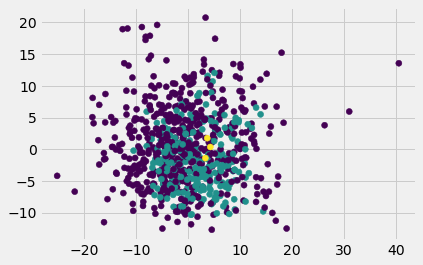

In [ ]:
plt.scatter(comp1, comp2, c=labels)

In [ ]:
anatomy_df = pd.DataFrame(data_train_anatomy)
labelsdb = pd.DataFrame({'labeldb':labels})

##### hide

In [ ]:
def reduceDim2(df, target, method_class = PCA, df_name='Dataset',  **method_params):
    plt.figure(figsize=(10,10))
    plt.title('Reducción de dimensionalidad con {0} para dataset {1}'.format(method_class.__name__, df_name))
    
    target_df=pd.DataFrame({'ind': target.index, 'className': target.values})
    
    method_instance = method_class(n_components=2, random_state = random_seed)
    method_instance.set_params(**method_params)
    principalComponents = method_instance.fit_transform(df)
    
    if method_class == PCA:
        print('Varianza explicada',method_instance.explained_variance_ratio_)
        print('Varianza explicada total',method_instance.explained_variance_ratio_.sum())
    if method_class == TSNE:
        print(' .. cantidad de iteraciones: ', method_instance.n_iter_)
        
    principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
    principalDf_comp = pd.concat([principalDf.reset_index(drop=True),target_df['className'].reset_index(drop=True)], axis=1)
    sns.scatterplot(data=principalDf_comp, x='PC1', y='PC2',
                    palette=sns.color_palette("hls", 3),
                    hue= "className",
                    s=80)
    plt.show()

##### cont

 .. cantidad de iteraciones:  999


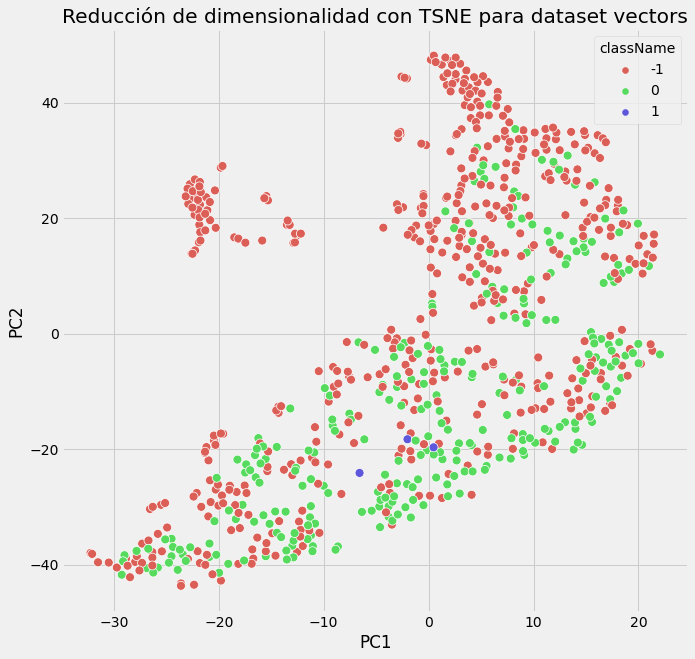

In [ ]:
reduceDim2(df=anatomy_df,target=labelsdb['labeldb'], method_class=TSNE, df_name='vectors')

In [ ]:
ids_labs_db = pd.concat([ids_labs,labelsdb], axis=1)

In [ ]:
db_labels_c1 = ids_labs_db[ids_labs_db['labeldb']==-1][['label','id']]
db_labels_c2 = ids_labs_db[ids_labs_db['labeldb']==0][['label','id']]

In [ ]:
pacientes_c1 = get_all_patients(db_labels_c1['id'].values, 'fmri_basc197')

mats = gen_matrices(pacientes_c1, tipo_matriz = 'correlation', as_distance = 'cosine', keep_pvalue= 0.05)

dgms = []
Len = len(mats)
for i in range(Len):
  dgm = ripser_diagram(mats[i])
  dgms.append(dgm)

Len = len(dgms)
diags_dict = {'Rips_dim_0': [],'Rips_dim_1': []}

for i in range(Len):
  diags_dict['Rips_dim_0'].append(dgms[i][0])
  diags_dict['Rips_dim_1'].append(dgms[i][1])


F = np.array([[]]*Len)

L = pd.Series(db_labels_c1['label'].values)
L = np.asarray(pd.get_dummies(L))

labs_df = pd.DataFrame({'label': db_labels_c1['label'].values})

D = diag_prepro(diags_dict, use_selector = True, use_prominent = False, thresh = 40, use_scaler = True, use_padding = True)

lend = len(D)
perslay_parameters = load_architecture_params(weight="None", len_d = lend, layer= "Landscape", perm_op = "sum")
vectors = vector_representations(D, perslay_parameters)

vec_df = pd.DataFrame(vectors)



Varianza explicada [0.91268194 0.04449252]
Varianza explicada total 0.9571745


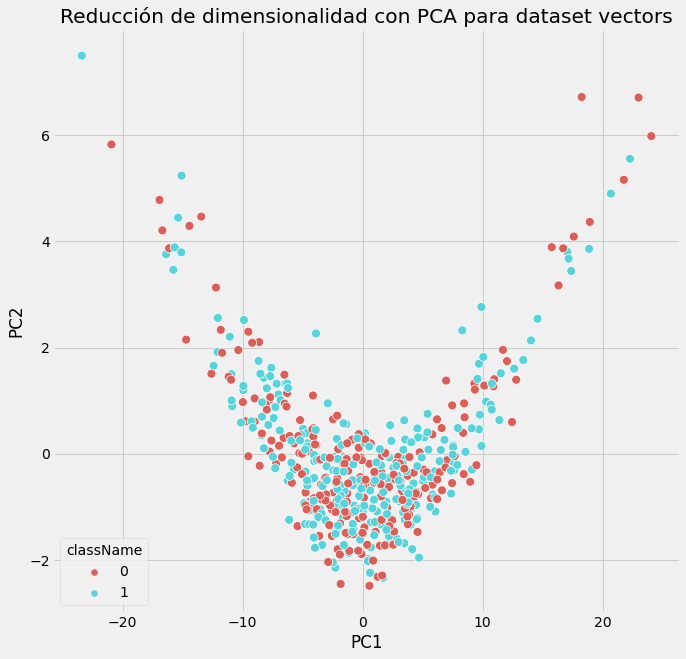

KFold(n_splits=10, random_state=1117, shuffle=True)


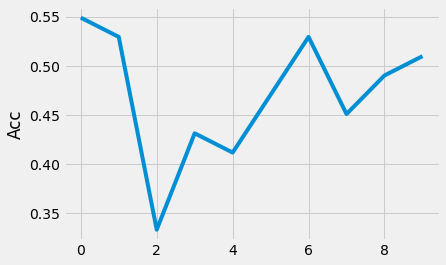

0.47058823529411764

In [ ]:
reduceDim(df=vec_df,target=labs_df['label'], method_class=PCA, df_name='vectors')

X = vec_df
y = labs_df['label']

splits = 10
kf = KFold(n_splits=splits, random_state=1117, shuffle=True)
kf.get_n_splits(X)

accuracy = []

print(kf)

for train_index, test_index in kf.split(X):
  X_train, X_test = X.loc[train_index], X.loc[test_index]
  y_train, y_test = y.loc[train_index], y.loc[test_index]

  # Create the model with 100 trees
  model = RandomForestClassifier(n_estimators=500, 
                                bootstrap = True,
                                max_features = 'sqrt')
  model.fit(X_train, y_train)
  rf_predictions = model.predict(X_test)
  acc = accuracy_score(y_test, rf_predictions)
  accuracy.append(acc)

plt.style.use("fivethirtyeight")
plt.plot(range(splits), accuracy)
plt.ylabel("Acc")
plt.show()

np.mean(accuracy)

Varianza explicada [0.8957708  0.04028056]
Varianza explicada total 0.93605137


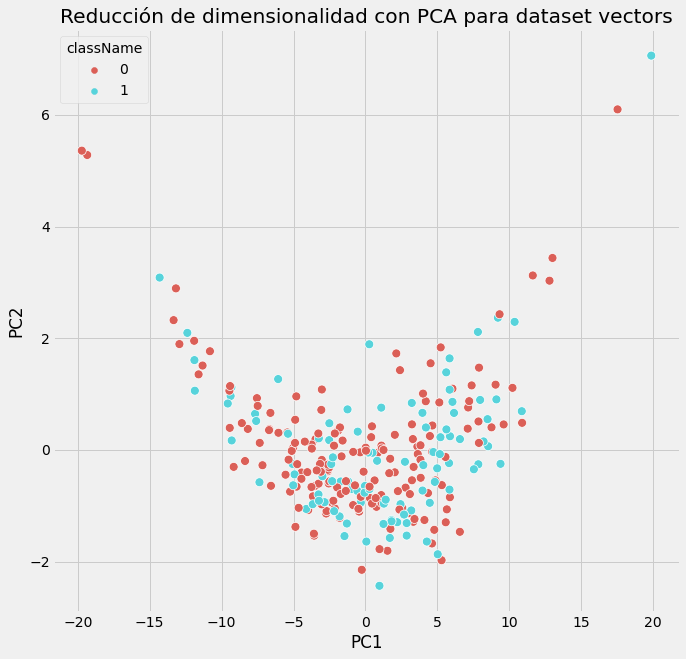

KFold(n_splits=10, random_state=1117, shuffle=True)


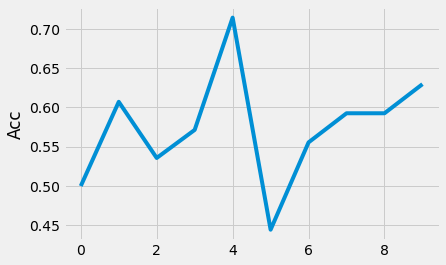

0.5743386243386244

In [ ]:
pacientes_c2 = get_all_patients(db_labels_c2['id'].values, 'fmri_basc197')

mats = gen_matrices(pacientes_c2, tipo_matriz = 'correlation', as_distance = 'cosine', keep_pvalue= 0.05)

dgms = []
Len = len(mats)
for i in range(Len):
  dgm = ripser_diagram(mats[i])
  dgms.append(dgm)

Len = len(dgms)
diags_dict = {'Rips_dim_0': [],'Rips_dim_1': []}

for i in range(Len):
  diags_dict['Rips_dim_0'].append(dgms[i][0])
  diags_dict['Rips_dim_1'].append(dgms[i][1])


F = np.array([[]]*Len)

L = pd.Series(db_labels_c2['label'].values)
L = np.asarray(pd.get_dummies(L))

labs_df = pd.DataFrame({'label': db_labels_c2['label'].values})

D = diag_prepro(diags_dict, use_selector = True, use_prominent = False, thresh = 40, use_scaler = True, use_padding = True)

lend = len(D)
perslay_parameters = load_architecture_params(weight="None", len_d = lend, layer= "Landscape", perm_op = "sum")
vectors = vector_representations(D, perslay_parameters)

vec_df = pd.DataFrame(vectors)

reduceDim(df=vec_df,target=labs_df['label'], method_class=PCA, df_name='vectors')

X = vec_df
y = labs_df['label']

splits = 10
kf = KFold(n_splits=splits, random_state=1117, shuffle=True)
kf.get_n_splits(X)

accuracy = []

print(kf)

for train_index, test_index in kf.split(X):
  X_train, X_test = X.loc[train_index], X.loc[test_index]
  y_train, y_test = y.loc[train_index], y.loc[test_index]

  # Create the model with 100 trees
  model = RandomForestClassifier(n_estimators=500, 
                                bootstrap = True,
                                max_features = 'sqrt')
  model.fit(X_train, y_train)
  rf_predictions = model.predict(X_test)
  acc = accuracy_score(y_test, rf_predictions)
  accuracy.append(acc)

plt.style.use("fivethirtyeight")
plt.plot(range(splits), accuracy)
plt.ylabel("Acc")
plt.show()

np.mean(accuracy)

# Try clusters por sexo

In [ ]:
data_train_anatomy.head()

,participants_site,participants_sex,participants_age,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,anatomy_lh_inferiorparietal_area,anatomy_lh_inferiortemporal_area,anatomy_lh_isthmuscingulate_area,anatomy_lh_lateraloccipital_area,anatomy_lh_lateralorbitofrontal_area,anatomy_lh_lingual_area,anatomy_lh_medialorbitofrontal_area,anatomy_lh_middletemporal_area,anatomy_lh_parahippocampal_area,anatomy_lh_paracentral_area,anatomy_lh_parsopercularis_area,anatomy_lh_parsorbitalis_area,anatomy_lh_parstriangularis_area,anatomy_lh_pericalcarine_area,anatomy_lh_postcentral_area,anatomy_lh_posteriorcingulate_area,anatomy_lh_precentral_area,anatomy_lh_precuneus_area,anatomy_lh_rostralanteriorcingulate_area,anatomy_lh_rostralmiddlefrontal_area,anatomy_lh_superiorfrontal_area,anatomy_lh_superiorparietal_area,anatomy_lh_superiortemporal_area,anatomy_lh_supramarginal_area,anatomy_lh_frontalpole_area,anatomy_lh_temporalpole_area,anatomy_lh_transversetemporal_area,anatomy_lh_insula_area,anatomy_lh_WhiteSurfArea_area,anatomy_rh_bankssts_area,anatomy_rh_caudalanteriorcingulate_area,...,anatomy_Right-Accumbens-area,anatomy_Right-VentralDC,anatomy_Right-vessel,anatomy_Right-choroid-plexus,anatomy_5th-Ventricle,anatomy_WM-hypointensities,anatomy_Left-WM-hypointensities,anatomy_Right-WM-hypointensities,anatomy_non-WM-hypointensities,anatomy_Left-non-WM-hypointensities,anatomy_Right-non-WM-hypointensities,anatomy_Optic-Chiasm,anatomy_CC_Posterior,anatomy_CC_Mid_Posterior,anatomy_CC_Central,anatomy_CC_Mid_Anterior,anatomy_CC_Anterior,anatomy_BrainSegVol,anatomy_BrainSegVolNotVentSurf,anatomy_lhCortexVol,anatomy_rhCortexVol,anatomy_CortexVol,anatomy_lhCerebralWhiteMatterVol,anatomy_rhCerebralWhiteMatterVol,anatomy_CerebralWhiteMatterVol,anatomy_SubCortGrayVol,anatomy_TotalGrayVol,anatomy_SupraTentorialVol,anatomy_SupraTentorialVolNotVent,anatomy_SupraTentorialVolNotVentVox,anatomy_MaskVol,anatomy_BrainSegVol-to-eTIV,anatomy_MaskVol-to-eTIV,anatomy_lhSurfaceHoles,anatomy_rhSurfaceHoles,anatomy_SurfaceHoles,anatomy_EstimatedTotalIntraCranialVol,anatomy_eTIV,anatomy_BrainSegVolNotVent,repetition_time
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6362958275326218968,22,0,16.00,1049.0,735.0,3157.0,1633.0,409.0,3894.0,5458.0,4634.0,1431.0,6113.0,2872.0,3154.0,2202.0,4265.0,877.0,1560.0,2142.0,848.0,1819.0,1449.0,5238.0,1824.0,5475.0,4533.0,1049.0,8287.0,8122.0,5783.0,4771.0,4589.0,344.0,486.0,447.0,3301.0,103856.0,1106.0,1016.0,...,699.4,4954.4,48.8,800.0,0.0,1043.0,0.0,0.0,0.0,0.0,0.0,76.8,1425.9,628.5,745.7,884.7,1248.0,1490487.0,1.452865e+06,329957.014708,325937.569371,655894.584079,282501.533759,279432.730141,561934.263900,73624.0,856918.584079,1.328929e+06,1.296439e+06,1291525.0,1958823.0,0.808868,1.063028,53.0,60.0,113.0,1.842682e+06,1.842682e+06,1452955.0,1.5
7111506141037153650,28,0,12.66,1150.0,752.0,2628.0,1760.0,611.0,3424.0,4090.0,3604.0,1203.0,5569.0,2934.0,3123.0,1642.0,3322.0,684.0,1542.0,1853.0,814.0,1729.0,1492.0,4740.0,1705.0,5531.0,4265.0,951.0,6673.0,8203.0,6216.0,4772.0,5586.0,318.0,488.0,557.0,3001.0,96918.8,945.0,737.0,...,722.1,4973.9,26.0,331.0,0.0,903.9,0.0,0.0,0.0,0.0,0.0,103.5,891.5,476.6,1010.1,939.0,885.1,1327255.0,1.316019e+06,296208.260557,296156.677480,592364.938036,247669.727580,244695.595368,492365.322948,68735.0,792125.938036,1.162800e+06,1.155780e+06,1153525.0,1804951.0,0.777365,1.057148,43.0,25.0,68.0,1.707377e+06,1.707377e+06,1316133.0,1.0
15632143337475166470,16,0,11.37,1043.0,603.0,2931.0,1413.0,360.0,3200.0,4511.0,3775.0,1135.0,5996.0,3486.0,3371.0,2077.0,3577.0,657.0,1656.0,1773.0,850.0,1595.0,1067.0,4325.0,1146.0,5351.0,4219.0,814.0,6308.0,8240.0,4977.0,4619.0,4456.0,299.0,501.0,450.0,2880.0,93631.2,1143.0,645.0,...,710.2,4286.3,45.7,426.8,0.0,713.8,0.0,0.0,0.0,0.0,0.0,157.7,749.0,521.7,450.9,426.4,876.4,1251012.0,1.236439e+06,314384.748489,31073

In [ ]:
data_train_anatomy = data_train_anatomy.drop(columns = ['participants_site'])
data_varones = data_train_anatomy[data_train_anatomy['participants_sex']==0]
data_mujeres = data_train_anatomy[data_train_anatomy['participants_sex']==1]

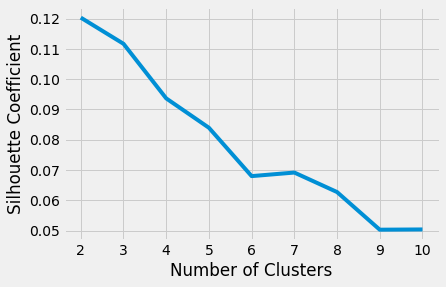

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_varones)

kmeans_kwargs = {"init": "random",
                 "n_init": 10,
                 "max_iter": 300,
                 "random_state": 42}

silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  score = silhouette_score(scaled_features, kmeans.labels_)
  silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

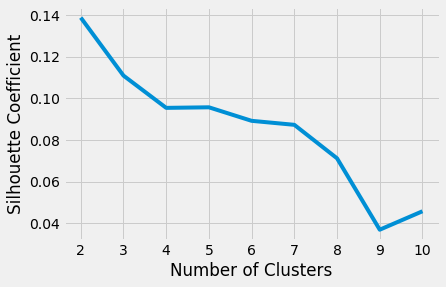

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_mujeres)

kmeans_kwargs = {"init": "random",
                 "n_init": 10,
                 "max_iter": 300,
                 "random_state": 42}

silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  score = silhouette_score(scaled_features, kmeans.labels_)
  silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()